In [4]:
!pip install missingno


✅ Dataset Loaded! Shape: (31875, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31875 entries, 0 to 31874
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   runDate                 31875 non-null  object 
 1   stations                31875 non-null  object 
 2   trainCode               31875 non-null  int64  
 3   trainStationId          31875 non-null  int64  
 4   scheduledArrival        31184 non-null  object 
 5   scheduledDeparture      31097 non-null  object 
 6   actualArrival           31875 non-null  object 
 7   actualDeparture         31775 non-null  object 
 8   distance                31875 non-null  int64  
 9   dayCount                31875 non-null  int64  
 10  ArrivalDelay            31875 non-null  int64  
 11  DepartureDelay          31875 non-null  int64  
 12  Number of Compartments  31875 non-null  int64  
 13  day_of_week             31875 non-null  object 
 14  t

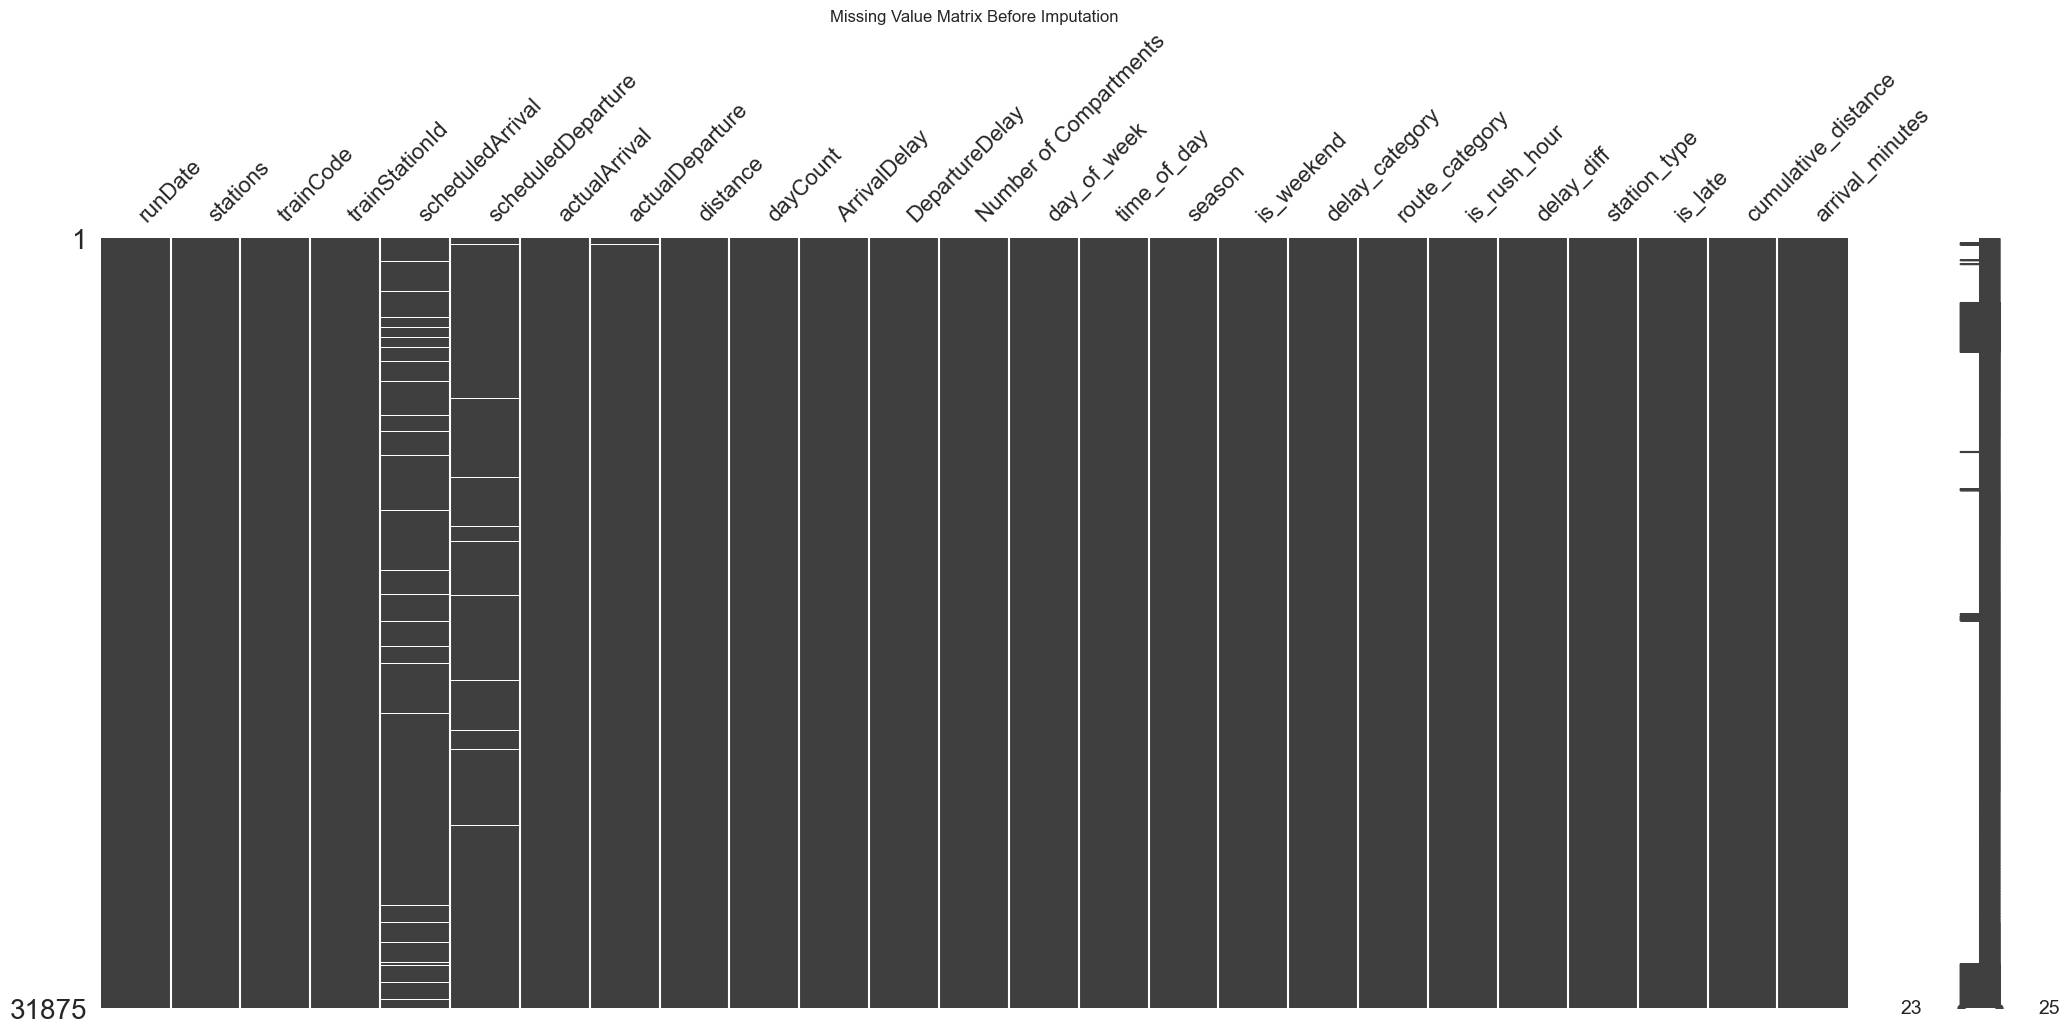

✅ Feature Engineering Complete!
✅ Dropped 0 records with missing times & delays.
✅ Data Preprocessing Complete!


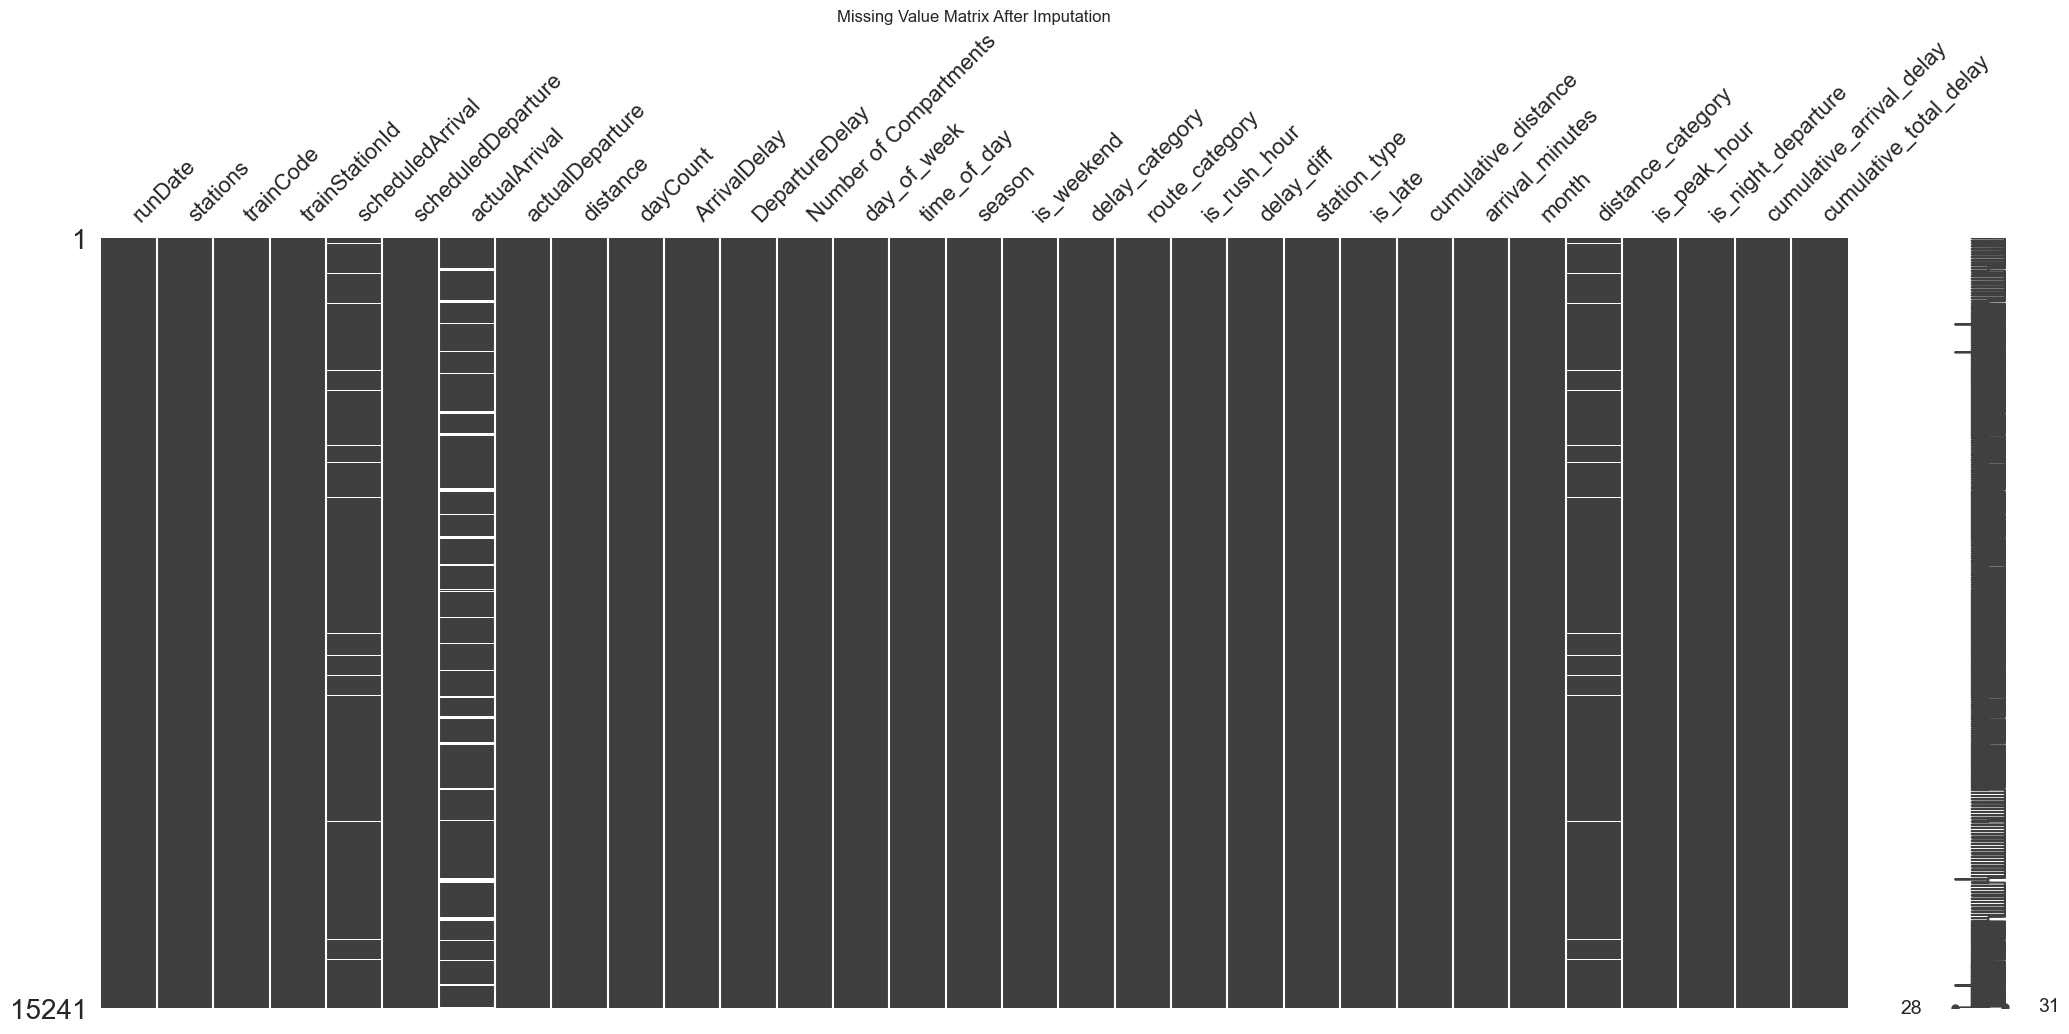


✅ Skewness of numeric features:
trainCode                   -0.495315
trainStationId               8.570369
distance                     0.518600
dayCount                     0.075663
ArrivalDelay                 3.997867
DepartureDelay               3.994572
Number of Compartments       2.928088
delay_diff                  23.621420
is_late                     -1.862755
cumulative_distance          0.319578
arrival_minutes              0.081749
month                        0.030774
is_peak_hour                 0.838943
is_night_departure           0.286500
cumulative_arrival_delay     4.903413
cumulative_total_delay       4.892517
dtype: float64

✅ Kurtosis of numeric features:
trainCode                    -1.194720
trainStationId               71.516295
distance                     -0.270482
dayCount                     -0.440491
ArrivalDelay                 25.005466
DepartureDelay               24.343076
Number of Compartments        7.638086
delay_diff                  869.315953

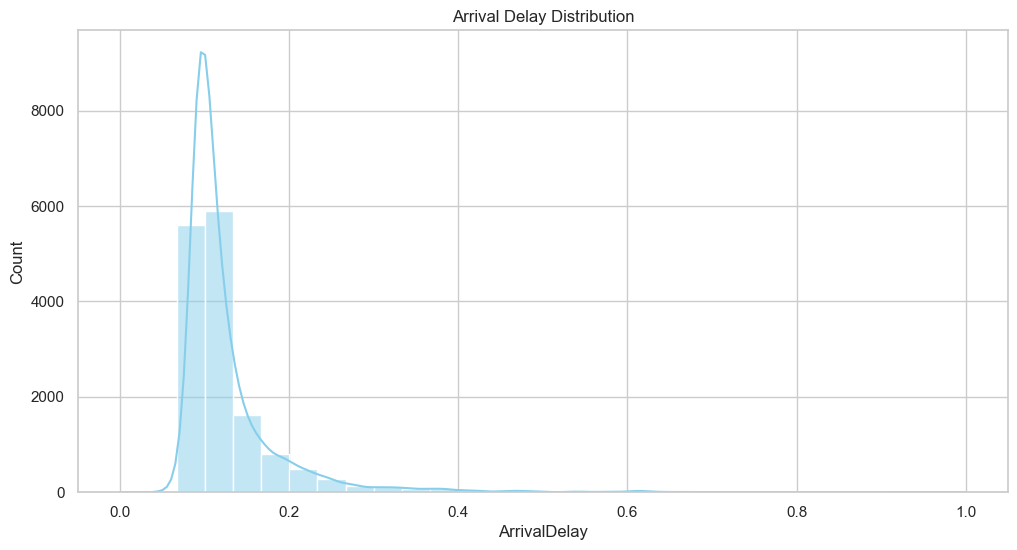

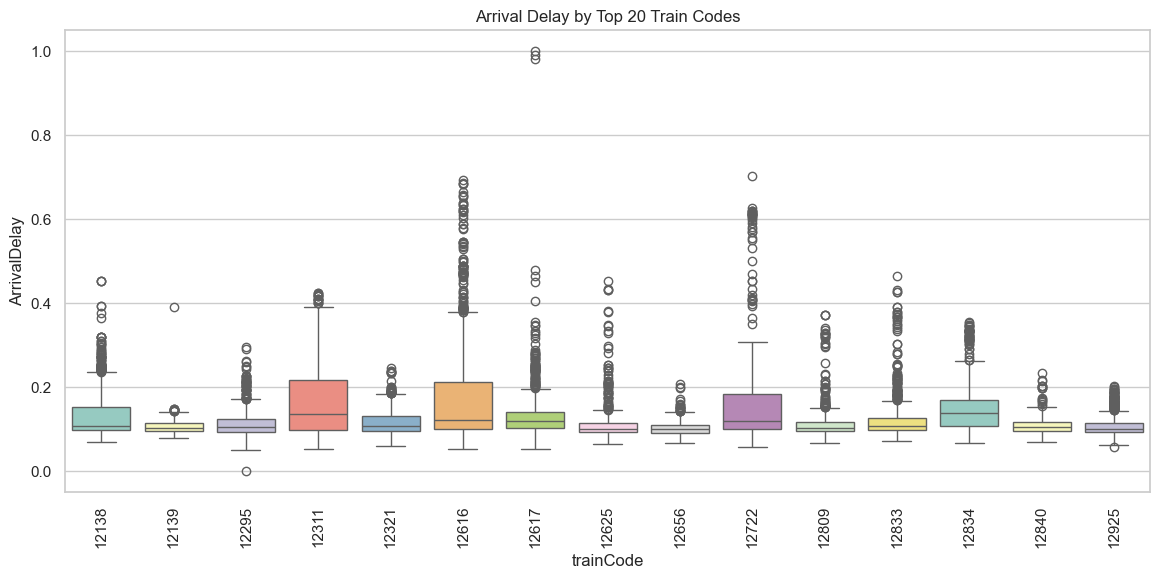

✅ Total outliers detected based on ArrivalDelay: 1467


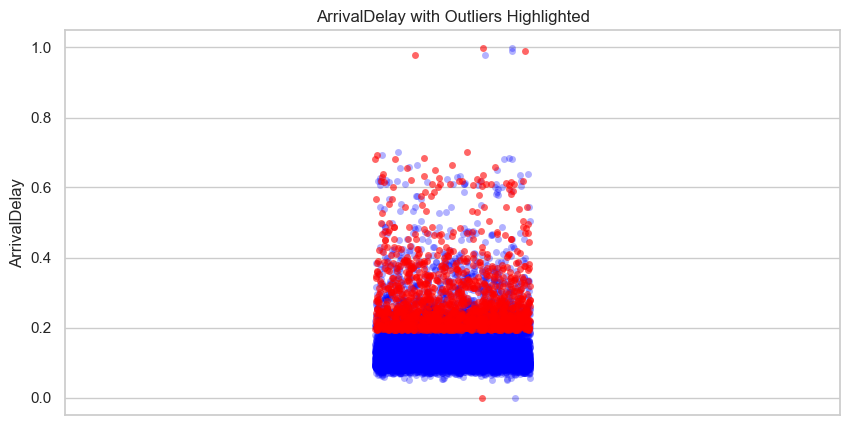

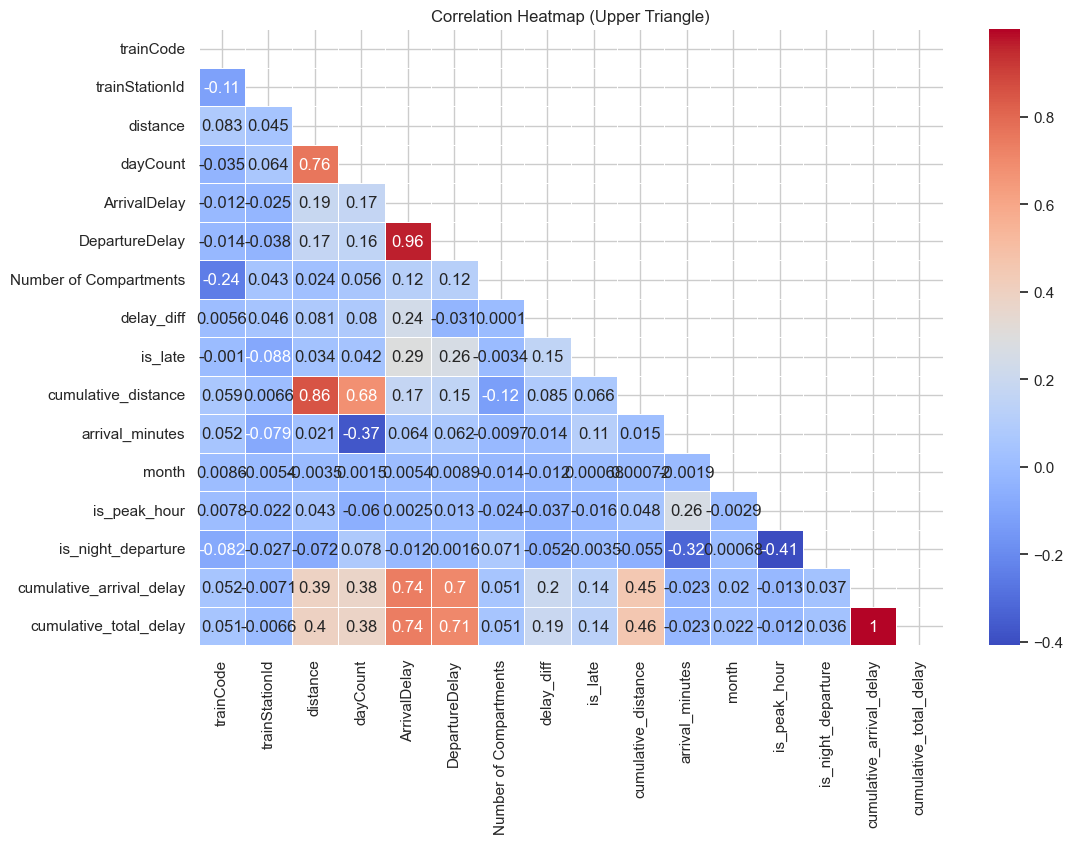

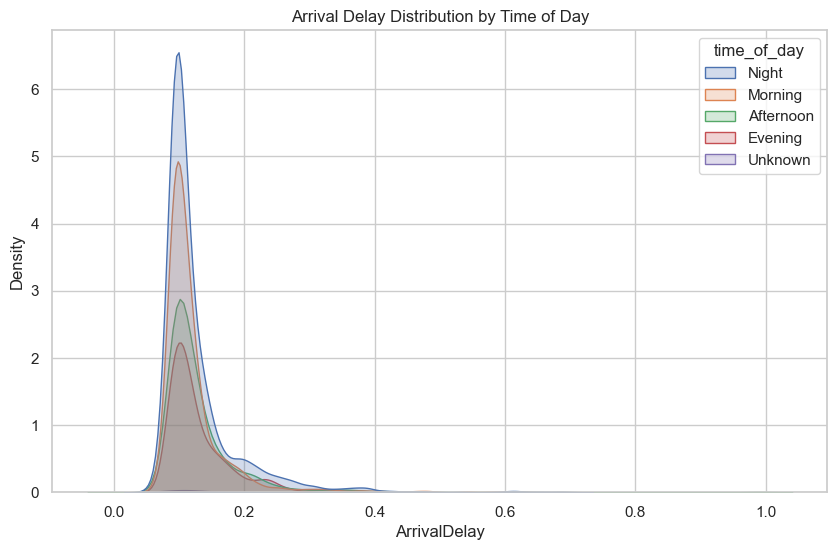

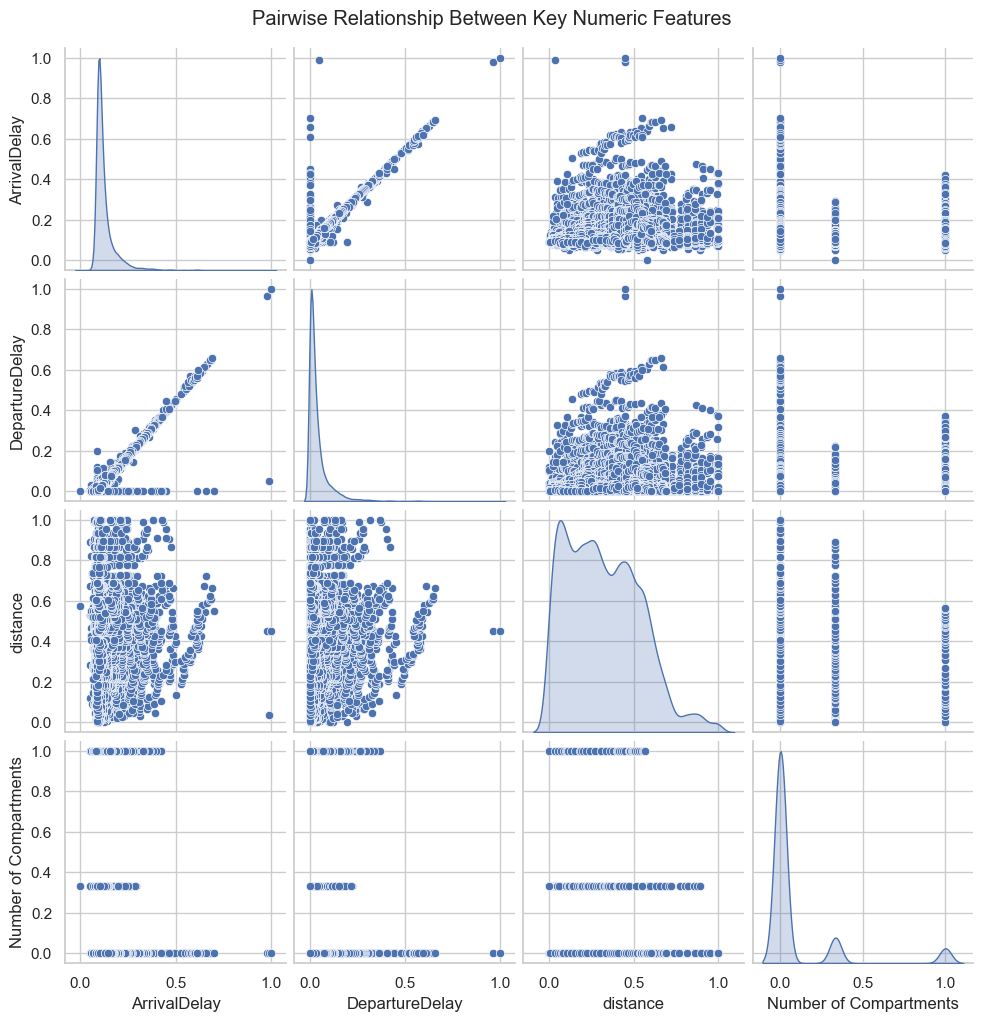

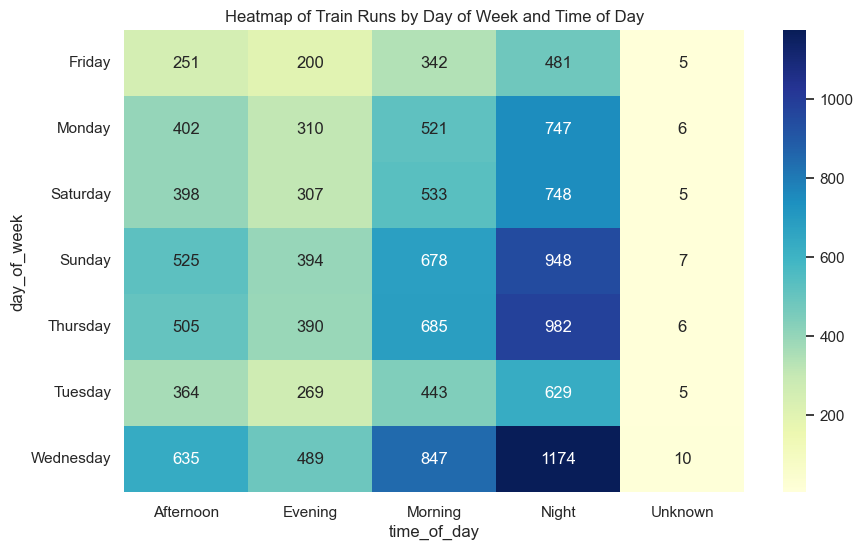

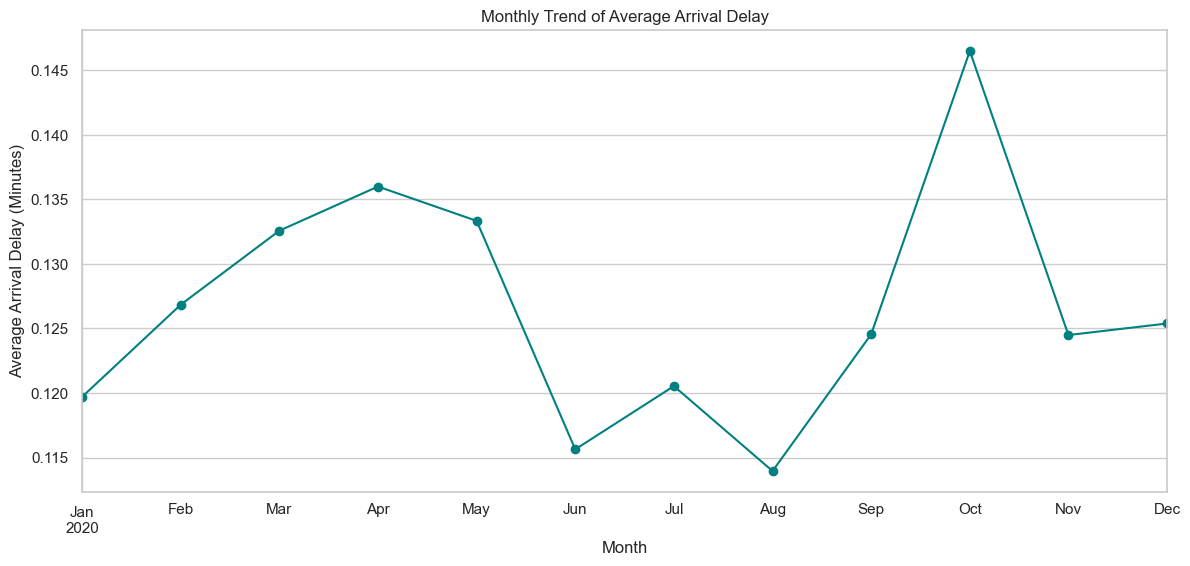

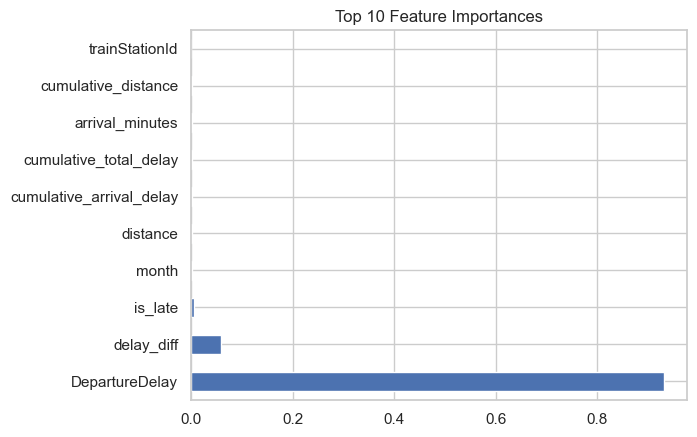

🚀 Final Dataset Saved: train_enriched_v2_preprocessed_final.csv


In [9]:
# ✅ Railway Delay Prediction - Final Combined Notebook

# 📚 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# ==============================
# 🚂 Load Dataset
# ==============================
file_path = 'train_enriched_v2.csv'
df = pd.read_csv(file_path)

print("✅ Dataset Loaded! Shape:", df.shape)
df.info()

# ==============================
# 🔎 Missing Value Analysis
# ==============================
print("\n📊 Initial Missing Values:")
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])

# Visualize missing data
msno.matrix(df)
plt.title('Missing Value Matrix Before Imputation')
plt.show()

# ==============================
# 🎯 Feature Engineering
# ==============================

# Convert runDate to datetime
df['runDate'] = pd.to_datetime(df['runDate'], dayfirst=True, errors='coerce')
df.dropna(subset=['runDate'], inplace=True)

# Extract day of week and month
df['day_of_week'] = df['runDate'].dt.day_name()
df['month'] = df['runDate'].dt.month

# Convert time columns
time_cols = ['scheduledArrival', 'scheduledDeparture', 'actualArrival', 'actualDeparture']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# Time of Day categorization
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['scheduledDeparture'].apply(
    lambda x: get_time_of_day(x.hour) if pd.notnull(x) else 'Unknown'
)

# Distance category
df['distance_category'] = pd.cut(
    df['distance'],
    bins=[0, 200, 500, 1000, np.inf],
    labels=['Short', 'Medium', 'Long', 'Very Long']
)

# Flags for peak and night departures
df['is_peak_hour'] = df['scheduledDeparture'].apply(
    lambda x: 1 if pd.notnull(x) and (7 <= x.hour <= 10 or 17 <= x.hour <= 20) else 0
)
df['is_night_departure'] = df['scheduledDeparture'].apply(
    lambda x: 1 if pd.notnull(x) and (x.hour < 6 or x.hour >= 20) else 0
)

# Cumulative delay features
df['cumulative_arrival_delay'] = df.groupby(['runDate', 'trainCode'])['ArrivalDelay'].cumsum()
df['cumulative_total_delay'] = df.groupby(['runDate', 'trainCode'])[['ArrivalDelay', 'DepartureDelay']].cumsum().sum(axis=1)

print("✅ Feature Engineering Complete!")

# ==============================
# 🛠️ Data Preprocessing
# ==============================

# Drop records where both scheduled times and delays are missing
drop_condition = (
    df['scheduledArrival'].isnull() & df['ArrivalDelay'].isnull()
) | (
    df['scheduledDeparture'].isnull() & df['DepartureDelay'].isnull()
)
rows_before = len(df)
df = df[~drop_condition]
rows_after = len(df)
print(f"✅ Dropped {rows_before - rows_after} records with missing times & delays.")

# Impute scheduledDeparture from actualDeparture - DepartureDelay
missing_sched_departure = df['scheduledDeparture'].isnull() & df['actualDeparture'].notnull() & df['DepartureDelay'].notnull()
df.loc[missing_sched_departure, 'scheduledDeparture'] = df.loc[missing_sched_departure, 'actualDeparture'] - pd.to_timedelta(df.loc[missing_sched_departure, 'DepartureDelay'], unit='m')

# Recalculate time_of_day after imputation
df['time_of_day'] = df['scheduledDeparture'].apply(
    lambda x: get_time_of_day(x.hour) if pd.notnull(x) else 'Unknown'
)

# Normalize numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['trainCode', 'trainStationId']
scaler_cols = [col for col in numeric_cols if col not in exclude_cols]

scaler = MinMaxScaler()
df[scaler_cols] = scaler.fit_transform(df[scaler_cols])

print("✅ Data Preprocessing Complete!")

# Confirm missing values handled
msno.matrix(df)
plt.title('Missing Value Matrix After Imputation')
plt.show()

# ==============================
# 📊 Data Distribution Statistics (Skewness & Kurtosis)
# ==============================

print("\n✅ Skewness of numeric features:")
print(df[numeric_cols].skew())

print("\n✅ Kurtosis of numeric features:")
print(df[numeric_cols].kurtosis())

# ==============================
# 🚀 Enhanced EDA Visualizations
# ==============================

sns.set_theme(style='whitegrid')

# ArrivalDelay distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['ArrivalDelay'], bins=30, kde=True, color='skyblue')
plt.title('Arrival Delay Distribution')
plt.show()

# Boxplot: ArrivalDelay by TrainCode (top 20 most frequent)
top_trains = df['trainCode'].value_counts().nlargest(20).index.tolist()
plt.figure(figsize=(14, 6))
sns.boxplot(x='trainCode', y='ArrivalDelay', data=df[df['trainCode'].isin(top_trains)], palette='Set3')
plt.xticks(rotation=90)
plt.title('Arrival Delay by Top 20 Train Codes')
plt.show()

# Outlier detection: IQR method
Q1 = df['ArrivalDelay'].quantile(0.25)
Q3 = df['ArrivalDelay'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['ArrivalDelay'] < (Q1 - 1.5 * IQR)) | (df['ArrivalDelay'] > (Q3 + 1.5 * IQR))]

print(f"✅ Total outliers detected based on ArrivalDelay: {outliers.shape[0]}")

plt.figure(figsize=(10, 5))
sns.stripplot(y=df['ArrivalDelay'], color='blue', alpha=0.3)
sns.stripplot(y=outliers['ArrivalDelay'], color='red', alpha=0.6)
plt.title('ArrivalDelay with Outliers Highlighted')
plt.show()

# Correlation heatmap (upper triangle masking)
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Upper Triangle)')
plt.show()

# KDE Plot: ArrivalDelay distribution by time_of_day
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='ArrivalDelay', hue='time_of_day', fill=True)
plt.title('Arrival Delay Distribution by Time of Day')
plt.show()

# Pairplot for numeric features
sns.pairplot(df[['ArrivalDelay', 'DepartureDelay', 'distance', 'Number of Compartments']], diag_kind='kde')
plt.suptitle('Pairwise Relationship Between Key Numeric Features', y=1.02)
plt.show()

# Categorical Heatmap: Day of week vs time_of_day count
pivot_table = df.pivot_table(index='day_of_week', columns='time_of_day', aggfunc='size', fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Train Runs by Day of Week and Time of Day')
plt.show()

# Delay trends over time (monthly)
df['year_month'] = df['runDate'].dt.to_period('M')
monthly_delays = df.groupby('year_month')['ArrivalDelay'].mean()
plt.figure(figsize=(14, 6))
monthly_delays.plot(marker='o', linestyle='-', color='teal')
plt.title('Monthly Trend of Average Arrival Delay')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.grid(True)
plt.show()

# ==============================
# 🔥 Feature Importance Preview
# ==============================

X = df.select_dtypes(include=[np.number]).drop(columns=['ArrivalDelay'])
y = df['ArrivalDelay']

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

# ==============================
# ✅ Save the Final Dataset
# ==============================
output_file = 'train_enriched_v2_preprocessed_final.csv'
df.to_csv(output_file, index=False)
print(f"🚀 Final Dataset Saved: {output_file}")